In [7]:
import numpy as np
import os
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters
)

from sde.experiment_reports_owen import (
    PlotResults,
    sample_data
)

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# notebook parameters
n_dimensions = 1
step_size = 1e-1
n_pts = 10000
n_subsample = 1000

random_seed = 1

In [9]:
# network parameters
validation_split = .1
ARFF_validation_split = .1

drift_param = NNHyperparameters(K=2**5, 
                                M_min=5,
                                M_max=50,
                                lambda_reg=2e-3,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               lambda_reg=drift_param.lambda_reg,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diff')



In [10]:
# true functions parameters
def true_drift(x, param=None):
    return -0.5*x


def true_diffusion(x, param=None):
    return 0*(x*x)*0.01+np.sqrt(.01)


def true_drift_diffusion(x, param=None):
    return true_drift(x), true_diffusion(x)


xlim = np.array([[-1, 1]])

step_sizes = np.zeros((n_pts, 1)) + step_size


In [11]:
# train networks
No_of_tests = 10
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    rng = np.random.default_rng(random_seed + i)

    # generate data
    x_data, y_data, _ = sample_data(true_drift_diffusion, step_size, n_pts, n_subsample, rng, xlim)
    
    # build network
    SAT = SDEARFFTrain(n_dimensions=n_dimensions, rng=rng, resampling=True)

    # train network
    hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusion, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, plot=False)
    
    training_time[i] = hist.history["training_time"]
    val_loss[i] = hist.history["val_loss"]


drift epoch: 28
diff epoch: 5
Drift RMSE: 0.013720842914495334
Diffusion RMSE: 0.004163881473855413
Observed loss: -2.0754048298087664
Observed validation loss: -2.077323399817695
True loss: -2.075374927010015
Training time: 0.9245002269744873
drift epoch: 5
diff epoch: 5
Drift RMSE: 0.023049781422774012
Diffusion RMSE: 0.0023532701168872414
Observed loss: -2.0605310840595332
Observed validation loss: -2.035658740424535
True loss: -2.0372299745076203
Training time: 0.23394536972045898
drift epoch: 17
diff epoch: 5
Drift RMSE: 0.006280070489489743
Diffusion RMSE: 0.0008946409872655077
Observed loss: -2.0453534813902614
Observed validation loss: -2.0336900673670635
True loss: -2.0341978751557828
Training time: 0.5072197914123535
drift epoch: 11
diff epoch: 20
Drift RMSE: 0.009361076788063985
Diffusion RMSE: 0.0030692280549226244
Observed loss: -2.066128976067192
Observed validation loss: -2.0230747912116147
True loss: -2.02316570210011
Training time: 0.6738214492797852
drift epoch: 5
dif

Theoretical mean min loss: -2.0349391062863957
Loss standard deviation: 0.007453559924999299
Validation loss standard deviation: 0.022360679774997897


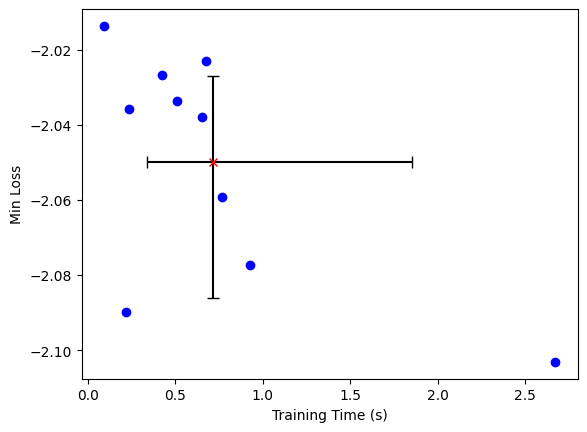

Mean Min Loss:  -2.049998557813263
Mean Training Time:  0.7165935039520264


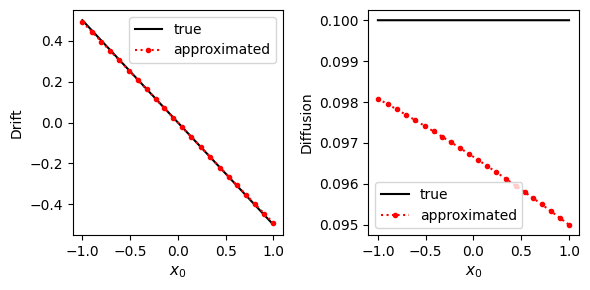

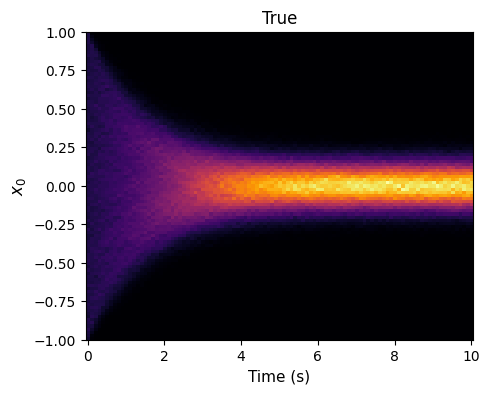

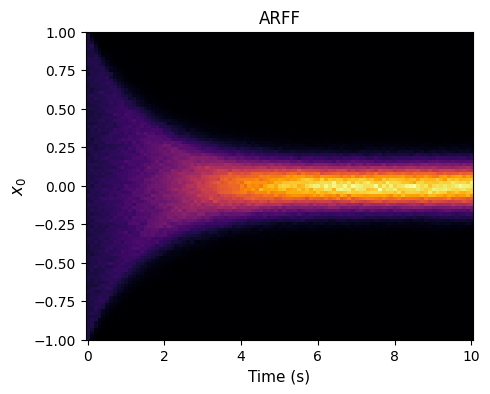

In [12]:
# display and save plots
PR = PlotResults(script_dir=script_dir, filename=filename, n_subsample=n_subsample)

# calculate theoretical mean min loss (integral over loss function across input domain)
PR.mean_min_loss(true_diffusion, n_pts, validation_split, step_size, xlim, save=True)

if No_of_tests > 1:
    PR.loss_stats(training_time, val_loss, save=True)

PR.plot_results_functions(SAT.drift_diffusion, true_drift_diffusion, x_data, save=True)

time = 100*step_size
PR.plot_histogram(true_drift_diffusion, step_size, time, rng, xlim, name='True', save=True)
PR.plot_histogram(SAT.drift_diffusion, step_size, time, rng, xlim, name='ARFF', save=True)
